In [22]:
import os

from hmmlearn import hmm
from models_gaussian import GaussianDenseHMM, HMMLoggingMonitor, DenseHMMLoggingMonitor
import joblib
import json
from pathlib import Path
import optuna
import multiprocessing as mp
from eval_utils import *
import tqdm
from eval_disrupted import disruptions
import itertools
import  matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

In [9]:
dsize = (100,  200, 3)  #  (s, T, n)
simple_model = True

In [10]:
np.random.seed(2022)
s = dsize[0]
T = dsize[1]
n = dsize[2]
pi, A, mu, sigma = prepare_params(n, simple_model)

In [11]:
nodes_tmp = mu

In [12]:
def visualize(nodes, mu, sigma, Y_true, title=""):
    plt.vlines(nodes, np.zeros(nodes.shape), np.ones(nodes.shape) * 0.33, color="blue", alpha = 0.8)
    plt.hist(Y_true, bins=[i for i in range(int(min(Y_true)-1),  int(max(Y_true)+1))], color="black", density=True) #
    plt.xlim([int(min(Y_true)-10),  int(max(Y_true)+10)])
    x = np.linspace(min(mu) - 3 * max(sigma) - 20, max(mu) + 3*max(sigma) + 20, 10000)
    for i in range(n):
        plt.plot(x, stats.norm.pdf(x, mu[i], sigma[i]), label=str(i), color="red")
    plt.title(title)
    plt.savefig(f"plots/{title.replace(' ',  '_')}.png")
    plt.show()

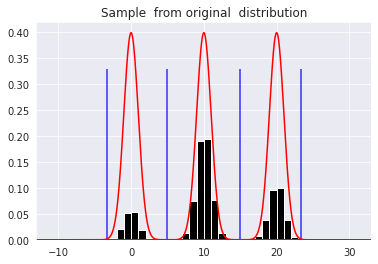

In [13]:
np.random.seed(2023)
data = [my_hmm_sampler(pi, A, mu, sigma, T) for _ in range(s)]
X_true = np.concatenate([np.concatenate(y[0]) for y in data])  # states
Y_true = np.concatenate([x[1] for x in data])  # observations
lengths = [len(x[1]) for x in data]

nodes = np.concatenate([np.array([-np.infty, Y_true.min()]),
                        (nodes_tmp[1:] + nodes_tmp[:-1]).reshape(-1) / 2,
                        np.array([Y_true.max(), np.infty])])

visualize(nodes, mu, sigma, Y_true, "Sample  from original  distribution")

generate_data_1 0.01


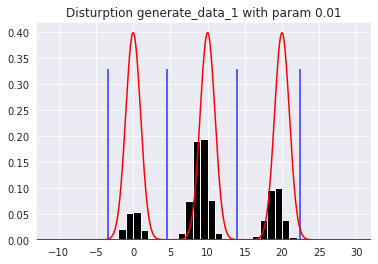

generate_data_1 0.05


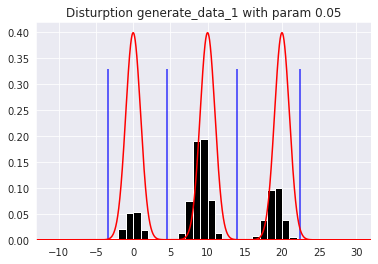

generate_data_1 0.1


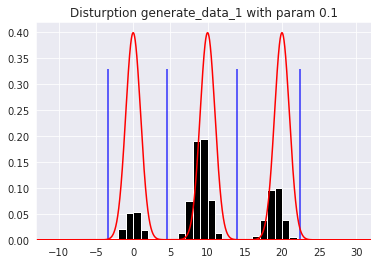

generate_data_1 0.25


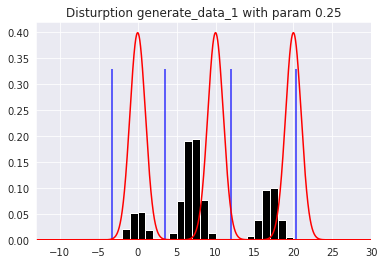

generate_data_1 0.5


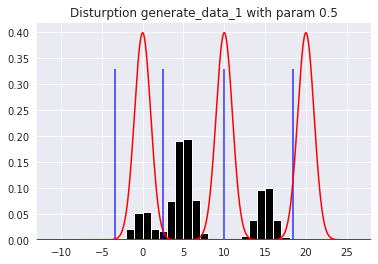

generate_data_1 0.75


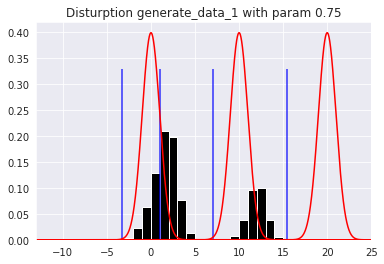

generate_data_2 0.01


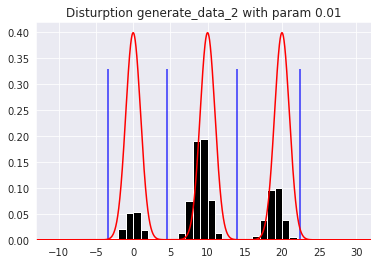

generate_data_2 0.05


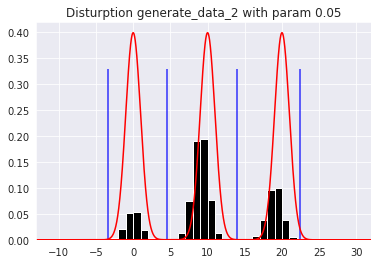

generate_data_2 0.1


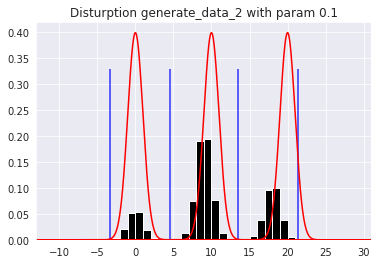

generate_data_2 0.25


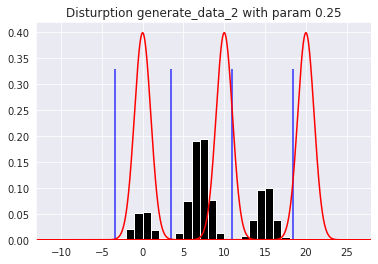

generate_data_2 0.5


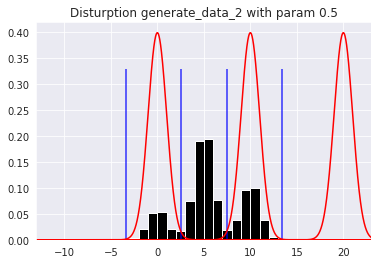

generate_data_2 0.75


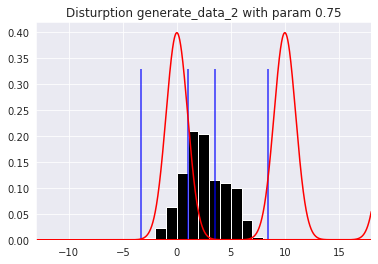

generate_data_3 0.01


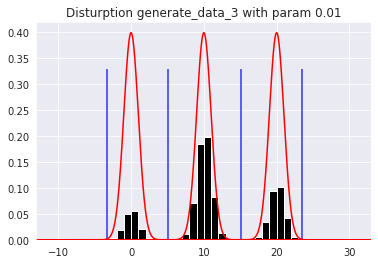

generate_data_3 0.05


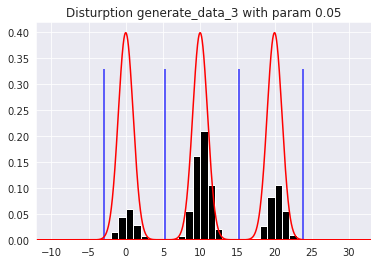

generate_data_3 0.1


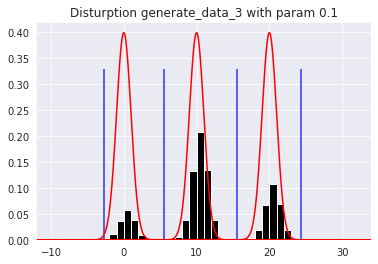

generate_data_3 0.25


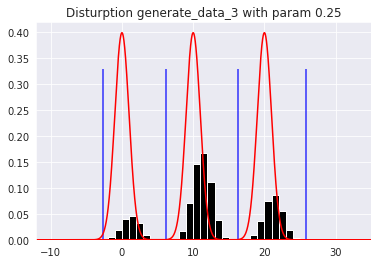

generate_data_3 0.5


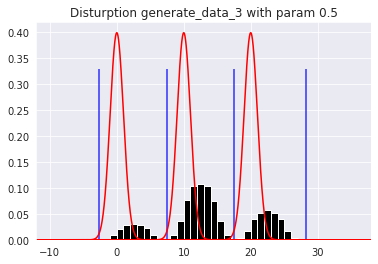

generate_data_3 0.75


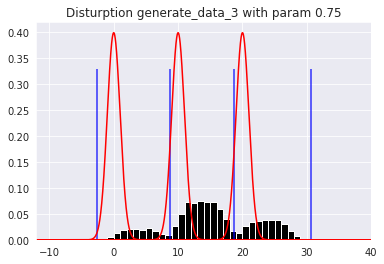

In [14]:
for disruption_data_generator, param in itertools.product(disruptions,  [0.01, 0.05,  0.1, 0.25, 0.5,  0.75]):
    np.random.seed(2023)
    print(disruption_data_generator.__name__,  param)
    X_true, Y_true, lengths, nodes = disruption_data_generator(pi, A, mu, sigma, T, s, param)
    visualize(nodes, mu, sigma, Y_true, f"Disturption {disruption_data_generator.__name__} with param {param}")

In [31]:
l_fixed = True
for disruption, param in itertools.product(range(1, len(disruptions)+1),  [0.01, 0.05,  0.1, 0.25, 0.5,  0.75]):
    if (disruption < 3) & (param < 0.2):
        continue
    print("\n\n", disruption, param)
    with open(f"gaussian_dense_hmm_benchmark/eval-disrupted-fixed-2022-8-23/best_result_d{disruption}_p{param}_s{s}_T{T}_n{n}_simple_model{simple_model}_l{l_fixed}.json", "r") as f:
        try:
            best_result = pd.DataFrame(json.load(f)["dense"])
            display(best_result.min().round(3).astype(str) + " - " +best_result.max().round(3).astype(str) + " (" + best_result.mean().round(3).astype(str) + ")")
        except:
            print(f"gaussian_dense_hmm_benchmark/eval-disrupted-fixed-2022-8-23/best_result_d{disruption}_p{param}_s{s}_T{T}_n{n}_simple_model{simple_model}_l{l_fixed}.json")



 1 0.25


time                      912.381 - 953.371 (941.24)
logprob          -50309.526 - -45066.04 (-47314.958)
acc                              0.996 - 1.0 (0.998)
dtv_transmat                   0.006 - 0.025 (0.016)
dtv_startprob                  0.002 - 0.005 (0.003)
MAE_means                        1.993 - 2.267 (2.1)
MAE_sigma                      0.536 - 1.307 (0.921)
dtv_omega                      0.093 - 0.187 (0.125)
dtype: object



 1 0.5


time                        926.118 - 951.887 (943.769)
logprob          -485274.244 - -45650.012 (-134102.928)
acc                                0.814 - 0.996 (0.94)
dtv_transmat                      0.007 - 0.032 (0.019)
dtv_startprob                     0.002 - 0.004 (0.004)
MAE_means                           3.31 - 3.576 (3.42)
MAE_sigma                         0.457 - 0.944 (0.723)
dtv_omega                         0.094 - 0.188 (0.121)
dtype: object



 1 0.75


time                       921.617 - 955.745 (946.174)
logprob          -184668.759 - -42047.321 (-92517.094)
acc                              0.624 - 0.957 (0.829)
dtv_transmat                     0.025 - 0.527 (0.128)
dtv_startprob                    0.002 - 0.112 (0.026)
MAE_means                        5.181 - 7.024 (5.507)
MAE_sigma                        0.172 - 1.119 (0.694)
dtv_omega                        0.112 - 0.174 (0.129)
dtype: object



 2 0.25


time                        919.353 - 939.19 (930.947)
logprob          -189535.937 - -50790.867 (-76291.717)
acc                               0.674 - 0.997 (0.94)
dtv_transmat                      0.007 - 0.083 (0.02)
dtv_startprob                    0.002 - 0.016 (0.005)
MAE_means                        2.526 - 2.855 (2.693)
MAE_sigma                        0.398 - 1.703 (0.838)
dtv_omega                        0.094 - 0.189 (0.125)
dtype: object



 2 0.5


time                        914.229 - 944.705 (931.668)
logprob          -601770.164 - -47184.793 (-140182.634)
acc                               0.546 - 0.987 (0.857)
dtv_transmat                      0.013 - 0.249 (0.062)
dtv_startprob                     0.005 - 0.148 (0.027)
MAE_means                         4.873 - 5.222 (4.997)
MAE_sigma                         0.422 - 3.037 (1.061)
dtv_omega                         0.095 - 0.169 (0.129)
dtype: object



 2 0.75


time                        922.561 - 957.647 (943.947)
logprob          -293663.819 - -48673.001 (-101720.075)
acc                               0.502 - 0.827 (0.692)
dtv_transmat                      0.086 - 0.463 (0.151)
dtv_startprob                     0.025 - 0.053 (0.034)
MAE_means                        7.565 - 10.787 (8.027)
MAE_sigma                         0.705 - 0.949 (0.816)
dtv_omega                         0.118 - 0.161 (0.134)
dtype: object



 3 0.01


time                       925.232 - 951.662 (936.089)
logprob          -300597.244 - -46061.457 (-88348.351)
acc                                0.662 - 1.0 (0.949)
dtv_transmat                      0.007 - 0.103 (0.04)
dtv_startprob                     0.004 - 0.02 (0.009)
MAE_means                         0.058 - 0.31 (0.184)
MAE_sigma                        0.459 - 3.237 (1.662)
dtv_omega                        0.094 - 0.189 (0.129)
dtype: object



 3 0.05


time                      925.456 - 954.454 (937.868)
logprob          -269465.788 - -45206.736 (-82580.63)
acc                               0.617 - 1.0 (0.945)
dtv_transmat                    0.007 - 0.111 (0.032)
dtv_startprob                   0.003 - 0.021 (0.007)
MAE_means                       0.221 - 0.739 (0.346)
MAE_sigma                       0.465 - 3.305 (1.405)
dtv_omega                       0.092 - 0.167 (0.116)
dtype: object



 3 0.1


time                         926.973 - 954.635 (941.72)
logprob          -416049.216 - -47560.642 (-143804.608)
acc                                 0.625 - 1.0 (0.907)
dtv_transmat                      0.006 - 0.504 (0.091)
dtv_startprob                     0.003 - 0.086 (0.018)
MAE_means                         0.389 - 6.794 (1.356)
MAE_sigma                           0.66 - 3.197 (1.52)
dtv_omega                         0.092 - 0.184 (0.118)
dtype: object



 3 0.25


time                        929.741 - 952.804 (942.268)
logprob          -262931.125 - -49742.585 (-116383.567)
acc                                  0.751 - 1.0 (0.93)
dtv_transmat                      0.006 - 0.096 (0.018)
dtv_startprob                     0.003 - 0.017 (0.006)
MAE_means                           0.871 - 1.347 (1.2)
MAE_sigma                         0.514 - 3.423 (1.266)
dtv_omega                          0.093 - 0.187 (0.13)
dtype: object



 3 0.5


time                       926.786 - 949.045 (940.72)
logprob          -85109.891 - -55383.683 (-66314.173)
acc                             0.726 - 0.999 (0.947)
dtv_transmat                    0.006 - 0.089 (0.029)
dtv_startprob                   0.002 - 0.017 (0.006)
MAE_means                       2.353 - 2.659 (2.514)
MAE_sigma                         0.424 - 3.37 (2.03)
dtv_omega                       0.094 - 0.166 (0.141)
dtype: object



 3 0.75


time                        920.397 - 951.269 (937.411)
logprob          -272264.359 - -68015.145 (-120469.519)
acc                               0.724 - 0.993 (0.873)
dtv_transmat                      0.013 - 0.086 (0.024)
dtv_startprob                     0.004 - 0.017 (0.007)
MAE_means                         3.766 - 3.953 (3.796)
MAE_sigma                         0.662 - 4.168 (1.573)
dtv_omega                         0.094 - 0.187 (0.122)
dtype: object

In [37]:
l_fixed = True
for disruption, param in itertools.product(range(1, len(disruptions)+1),  [0.01, 0.05,  0.1, 0.25, 0.5,  0.75]):
    if (disruption < 3) & (param < 0.2):
        continue
    print("\n\n", disruption, param)
    with open(f"gaussian_dense_hmm_benchmark/eval-disrupted-fixed-2022-8-24/best_result_hmmlearn_d{disruption}_p{param}_s{s}_T{T}_n{n}_simple_model{simple_model}_l{l_fixed}.json", "r") as f:
        try:
            best_result = pd.DataFrame(json.load(f)["HMMlearn"])
            display(best_result.min().round(3).astype(str) + " - " +best_result.max().round(3).astype(str) + " (" + best_result.mean().round(3).astype(str) + ")")
        except:
            print(f"gaussian_dense_hmm_benchmark/eval-disrupted-fixed-2022-8-24/best_result_hmmlearn_d{disruption}_p{param}_s{s}_T{T}_n{n}_simple_model{simple_model}_l{l_fixed}.json")



 1 0.25


time                         13.477 - 39.271 (33.927)
logprob          -44014.516 - -44014.516 (-44014.516)
acc                                   1.0 - 1.0 (1.0)
dtv_transmat                    0.007 - 0.007 (0.007)
dtv_startprob                   0.018 - 0.018 (0.018)
MAE_means                       1.993 - 1.993 (1.993)
MAE_sigma                       0.015 - 0.015 (0.015)
dtv_omega                       0.094 - 0.189 (0.124)
dtype: object



 1 0.5


time                         14.915 - 38.653 (33.996)
logprob          -43896.063 - -43896.063 (-43896.063)
acc                             0.998 - 0.998 (0.998)
dtv_transmat                    0.007 - 0.007 (0.007)
dtv_startprob                   0.018 - 0.018 (0.018)
MAE_means                       3.327 - 3.327 (3.327)
MAE_sigma                       0.016 - 0.016 (0.016)
dtv_omega                       0.094 - 0.188 (0.121)
dtype: object



 1 0.75


time                         15.701 - 40.419 (35.618)
logprob          -41838.542 - -41837.835 (-41838.191)
acc                             0.957 - 0.957 (0.957)
dtv_transmat                    0.023 - 0.023 (0.023)
dtv_startprob                   0.024 - 0.024 (0.024)
MAE_means                        5.36 - 5.361 (5.361)
MAE_sigma                        0.049 - 0.051 (0.05)
dtv_omega                         0.104 - 0.16 (0.12)
dtype: object



 2 0.25


time                         14.116 - 38.824 (33.487)
logprob          -44013.823 - -44013.823 (-44013.823)
acc                                   1.0 - 1.0 (1.0)
dtv_transmat                    0.007 - 0.007 (0.007)
dtv_startprob                   0.018 - 0.018 (0.018)
MAE_means                          2.66 - 2.66 (2.66)
MAE_sigma                       0.015 - 0.015 (0.015)
dtv_omega                       0.094 - 0.189 (0.124)
dtype: object



 2 0.5


time                         14.875 - 41.525 (35.518)
logprob          -43697.137 - -43697.137 (-43697.137)
acc                             0.994 - 0.994 (0.994)
dtv_transmat                    0.007 - 0.007 (0.007)
dtv_startprob                   0.019 - 0.019 (0.019)
MAE_means                       4.996 - 4.996 (4.996)
MAE_sigma                       0.018 - 0.018 (0.018)
dtv_omega                       0.094 - 0.166 (0.126)
dtype: object



 2 0.75


time                       16.684 - 40.448 (34.313)
logprob          -39737.985 - -39737.46 (-39737.82)
acc                           0.894 - 0.895 (0.894)
dtv_transmat                   0.06 - 0.061 (0.061)
dtv_startprob                 0.044 - 0.044 (0.044)
MAE_means                     7.766 - 7.767 (7.766)
MAE_sigma                      0.148 - 0.15 (0.149)
dtv_omega                       0.1 - 0.157 (0.121)
dtype: object



 3 0.01


time                           7.924 - 39.16 (32.465)
logprob          -44034.423 - -44034.423 (-44034.423)
acc                                   1.0 - 1.0 (1.0)
dtv_transmat                    0.007 - 0.007 (0.007)
dtv_startprob                   0.018 - 0.018 (0.018)
MAE_means                       0.058 - 0.058 (0.058)
MAE_sigma                       0.014 - 0.014 (0.014)
dtv_omega                       0.094 - 0.189 (0.129)
dtype: object



 3 0.05


time                          8.032 - 36.887 (31.636)
logprob          -44226.933 - -44226.933 (-44226.933)
acc                                   1.0 - 1.0 (1.0)
dtv_transmat                    0.007 - 0.007 (0.007)
dtv_startprob                   0.018 - 0.018 (0.018)
MAE_means                       0.258 - 0.258 (0.258)
MAE_sigma                       0.023 - 0.023 (0.023)
dtv_omega                       0.094 - 0.189 (0.117)
dtype: object



 3 0.1


time                          8.116 - 36.981 (31.733)
logprob          -44812.718 - -44812.718 (-44812.718)
acc                                   1.0 - 1.0 (1.0)
dtv_transmat                    0.007 - 0.007 (0.007)
dtv_startprob                   0.018 - 0.018 (0.018)
MAE_means                       0.508 - 0.508 (0.508)
MAE_sigma                       0.085 - 0.085 (0.085)
dtv_omega                       0.094 - 0.189 (0.124)
dtype: object



 3 0.25


time                           11.378 - 36.712 (32.2)
logprob          -48177.729 - -48177.729 (-48177.729)
acc                                   1.0 - 1.0 (1.0)
dtv_transmat                    0.007 - 0.007 (0.007)
dtv_startprob                   0.018 - 0.018 (0.018)
MAE_means                       1.257 - 1.257 (1.257)
MAE_sigma                       0.521 - 0.521 (0.521)
dtv_omega                       0.094 - 0.189 (0.133)
dtype: object



 3 0.5


time                          8.834 - 39.243 (33.813)
logprob          -55181.943 - -55181.943 (-55181.943)
acc                                   1.0 - 1.0 (1.0)
dtv_transmat                    0.007 - 0.007 (0.007)
dtv_startprob                   0.018 - 0.018 (0.018)
MAE_means                       2.505 - 2.505 (2.505)
MAE_sigma                       2.093 - 2.093 (2.093)
dtv_omega                       0.097 - 0.182 (0.145)
dtype: object



 3 0.75


time                           9.041 - 39.48 (33.628)
logprob          -60846.419 - -60846.419 (-60846.419)
acc                             0.991 - 0.991 (0.991)
dtv_transmat                    0.008 - 0.008 (0.008)
dtv_startprob                   0.015 - 0.015 (0.015)
MAE_means                       3.757 - 3.757 (3.757)
MAE_sigma                       4.963 - 4.963 (4.963)
dtv_omega                       0.108 - 0.165 (0.126)
dtype: object